# SPI Quantile Quality Control
a. stein 6.1.2022

In `analysis/usdm_spi_investigate_temporal.ipynb` found that D4 appears very overrepresented in the stacked timeseries for WA caf, so here I'm looking into what's up with that.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import rioxarray
import rasterio as rio
import pandas as pd
import geopandas as gpd

import matplotlib.dates as mdates

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import ndrought.wrangle as wrangle
import ndrought.compare as compare
import ndrought.plotting as ndplot

Populating the interactive namespace from numpy and matplotlib


/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [2]:
dm_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures'
spi_path = f'{dm_path}/spi/WA'

spi_intervals = ['14d', '30d', '90d', '180d', '270d', '1y', '2y', '5y', ]

spi = dict()
for spi_int in spi_intervals:
    spi[spi_int] = xr.open_dataset(f'{spi_path}/spi_{spi_int}.nc')['spi']

In [3]:
spi_nanless = dict()

for spi_int in spi_intervals:
    spi_nanless[spi_int] = spi[spi_int].values.ravel()[np.isnan(spi[spi_int].values.ravel()) == False]

In [4]:
spi_cdfs = dict()

for spi_int in tqdm(spi_intervals):
    spi_cdfs[spi_int] = wrangle.cunnane_empircal_cdf(spi_nanless[spi_int])

  0%|          | 0/8 [00:00<?, ?it/s]

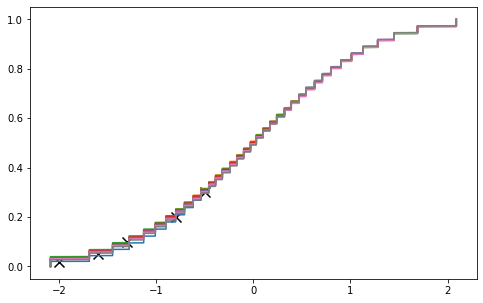

In [5]:
fig, ax = plt.subplots(figsize=(8,5))

for spi_int in spi_intervals:
    sorted, pos = spi_cdfs[spi_int]
    ax.plot(sorted, pos)

ax.scatter(-0.5, 0.3, color='k', marker='x', s=100)
ax.scatter(-0.8, 0.2, color='k', marker='x', s=100)
ax.scatter(-1.3, 0.1, color='k', marker='x', s=100)
ax.scatter(-1.6, 0.05, color='k', marker='x', s=100)
ax.scatter(-2.0, 0.02, color='k', marker='x', s=100)

In [6]:
tot = len(spi_cdfs['14d'][0])

In [7]:
for spi_int in spi_intervals:
    print(spi_int)
    tot = len(spi_cdfs[spi_int][0])
    for threshold, cat in zip([-0.5, -0.8, -1.3, -1.6, -2.0], ['D0', 'D1', 'D2', 'D3', 'D4']):
        print(f'{cat} {100*len(np.where(spi_cdfs[spi_int][0] <= threshold)[0])/tot:.2f}')
    print()

14d
D0 29.72
D1 20.87
D2 6.89
D3 4.36
D4 2.03

30d
D0 31.55
D1 23.25
D2 8.99
D3 6.09
D4 3.23

90d
D0 31.34
D1 23.21
D2 9.59
D3 6.79
D4 3.95

180d
D0 31.05
D1 22.87
D2 9.10
D3 6.32
D4 3.52

270d
D0 30.53
D1 22.44
D2 8.77
D3 6.02
D4 3.25

1y
D0 30.15
D1 22.10
D2 8.66
D3 5.96
D4 3.22

2y
D0 30.20
D1 21.94
D2 8.49
D3 5.83
D4 3.15

5y
D0 29.61
D1 21.44
D2 8.03
D3 5.37
D4 2.71



So those look fairly fine. Some ride a little high in D4, but not drastically so.

Did it get messed up when being put into categories?

In [8]:
spi_cat = xr.open_dataset(f'{spi_path}/spi_usdmcat_WA.nc')

In [9]:
spi_cat

<xarray.Dataset>
Dimensions:   (lat: 84, lon: 188, day: 1148)
Coordinates:
  * lat       (lat) float64 48.98 48.94 48.9 48.86 ... 45.65 45.61 45.57 45.53
  * lon       (lon) float64 -124.7 -124.7 -124.6 -124.6 ... -117.0 -117.0 -116.9
  * day       (day) datetime64[ns] 1999-12-31 2000-01-10 ... 2021-12-26
Data variables:
    spi_1y    (day, lat, lon) float32 ...
    spi_2y    (day, lat, lon) float32 ...
    spi_5y    (day, lat, lon) float32 ...
    spi_14d   (day, lat, lon) float32 ...
    spi_30d   (day, lat, lon) float32 ...
    spi_90d   (day, lat, lon) float32 ...
    spi_180d  (day, lat, lon) float32 ...
    spi_270d  (day, lat, lon) float32 ...
Attributes:
    author:       a. stein, 4/28/2022
    description:  Standardized Precipitation Index (SPI) gathered from variou...
    clipping:     Clipped to Washington state using http://eric.clst.org/asse...

In [10]:
print('DX (OG) (CAT)')

for spi_int in spi_intervals:
    print(spi_int)
    tot_cat = len(spi_cat[f"spi_{spi_int}"].values.ravel())
    tot_og = len(spi_cdfs[spi_int][0])
    for threshold_cat, threshold_q, cat in zip([0, 1, 2, 3, 4], [-0.5, -0.8, -1.3, -1.6, -2.0], ['D0', 'D1', 'D2', 'D3', 'D4']):
        cat_q = 100*len(np.where(spi_cat[f"spi_{spi_int}"].values.ravel() >= threshold_cat)[0])/tot_cat
        og_q = 100*len(np.where(spi_cdfs[spi_int][0] <= threshold_q)[0])/tot_og
        print(f'{cat} {og_q:.2f} {cat_q:.2f}')
    print()

DX (OG) (CAT)
14d
D0 29.72 25.75
D1 20.87 18.45
D2 6.89 6.73
D3 4.36 4.39
D4 2.03 2.20

30d
D0 31.55 28.09
D1 23.25 21.08
D2 8.99 8.45
D3 6.09 5.79
D4 3.23 3.18

90d
D0 31.34 28.77
D1 23.21 22.01
D2 9.59 10.16
D3 6.79 7.54
D4 3.95 4.67

180d
D0 31.05 28.80
D1 22.87 22.04
D2 9.10 9.53
D3 6.32 6.90
D4 3.52 4.11

270d
D0 30.53 27.56
D1 22.44 20.71
D2 8.77 8.91
D3 6.02 6.47
D4 3.25 3.87

1y
D0 30.15 27.03
D1 22.10 20.01
D2 8.66 8.57
D3 5.96 6.36
D4 3.22 3.95

2y
D0 30.20 26.34
D1 21.94 19.30
D2 8.49 7.92
D3 5.83 5.57
D4 3.15 3.10

5y
D0 29.61 21.26
D1 21.44 14.87
D2 8.03 6.18
D3 5.37 4.54
D4 2.71 2.52



So there are some differences between the two, but still not nearly as large of a jump as to create what is happening in the stacked plots.

In [11]:
caf_ds = xr.open_dataset(f'{dm_path}/ndrought_products/paired_USDM_SPI_caf.nc')

In [12]:
caf_ds

<xarray.Dataset>
Dimensions:               (index: 1148)
Coordinates:
  * index                 (index) int64 0 1 2 3 4 5 ... 1143 1144 1145 1146 1147
Data variables: (12/56)
    USDM_neutral_wet      (index) float64 ...
    USDM_D0               (index) float64 ...
    USDM_D1               (index) float64 ...
    USDM_D2               (index) float64 ...
    USDM_D3               (index) float64 ...
    USDM_D4               (index) float64 ...
    ...                    ...
    spi_270d_D1           (index) float64 ...
    spi_270d_D2           (index) float64 ...
    spi_270d_D3           (index) float64 ...
    spi_270d_D4           (index) float64 ...
    USDM Date             (index) datetime64[ns] ...
    SPI Date              (index) datetime64[ns] ...
Attributes:
    description:  Fraction of total non-nan area that is in that USDM drought...

In [37]:
for spi_int in spi_intervals:
    print(spi_int)
    cumulative_mean = 0
    cumulative_median = 0
    for cat in ['D4', 'D3', 'D2', 'D1' , 'D0']:
        mean = 100*np.mean(caf_ds[f'spi_{spi_int}_{cat}'].values)
        median = 100*np.median(caf_ds[f'spi_{spi_int}_{cat}'].values)
        max = 100*np.max(caf_ds[f'spi_{spi_int}_{cat}'].values)
        cumulative_mean += mean
        cumulative_median += median
        print(f'{cat} {cumulative_mean:.2f} {cumulative_median:.2f} {max:.2f}')

    print()

14d
D4 2.78 0.00 84.48
D3 5.53 0.01 68.14
D2 8.48 0.11 58.61
D1 23.26 6.89 74.53
D0 32.47 14.35 43.33

30d
D4 4.00 0.00 88.55
D3 7.30 0.05 51.31
D2 10.66 0.29 45.06
D1 26.58 10.67 83.87
D0 35.41 18.13 50.22

90d
D4 5.89 0.02 92.18
D3 9.50 0.16 56.27
D2 12.81 0.67 77.32
D1 27.74 10.77 73.00
D0 36.27 18.25 39.69

180d
D4 5.18 0.08 92.99
D3 8.70 0.51 55.45
D2 12.01 1.54 22.68
D1 27.79 14.22 67.99
D0 36.30 21.83 31.29

270d
D4 4.88 0.14 75.88
D3 8.16 0.81 42.18
D2 11.23 2.06 24.18
D1 26.11 13.93 59.17
D0 34.75 21.75 31.81

1y
D4 4.98 0.20 78.46
D3 8.02 1.00 24.37
D2 10.80 2.15 21.71
D1 25.23 13.69 61.22
D0 34.08 22.11 30.38

2y
D4 3.91 0.28 34.15
D3 7.02 0.78 24.18
D2 9.98 1.50 17.45
D1 24.33 9.68 62.10
D0 33.21 17.33 31.22

5y
D4 3.18 0.19 72.15
D3 5.73 0.65 40.32
D2 7.79 1.33 19.74
D1 18.75 8.29 48.78
D0 26.81 13.83 26.24



What if I just plot all the data.

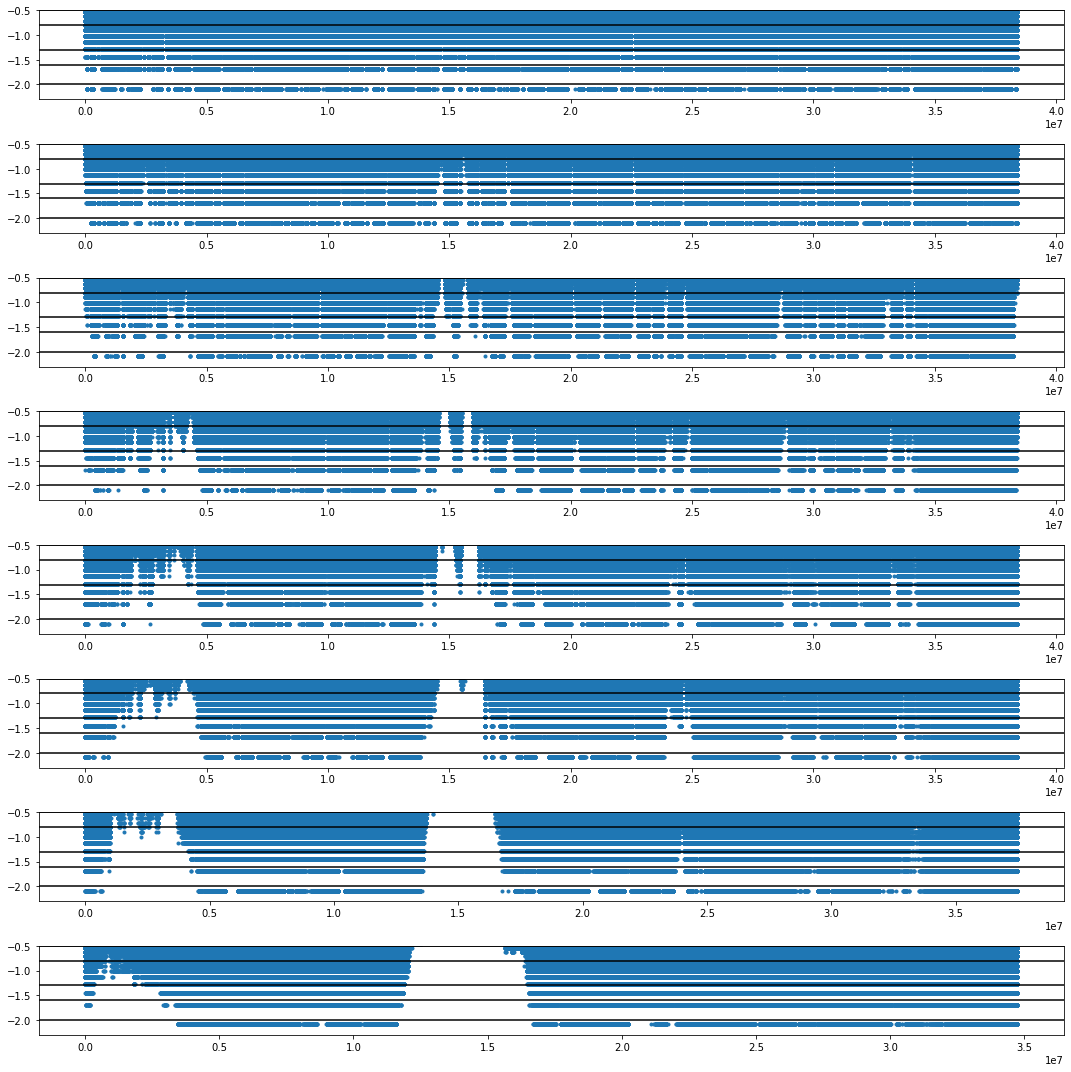

In [17]:
fig, axs = plt.subplots(len(spi_intervals), 1, figsize = (15,15))

for ax, spi_int in zip(axs.ravel(), spi_intervals):

    ax.plot(spi_nanless[spi_int], linestyle='', marker='.')
    bot, top = ax.get_ylim()
    ax.set_ylim(top=-0.5, bottom=bot)
    ax.axhline(-0.5, color='k')
    ax.axhline(-0.8, color='k')
    ax.axhline(-1.3, color='k')
    ax.axhline(-1.6, color='k')
    ax.axhline(-2.0, color='k')

plt.tight_layout()

Okay .. yeah those don't look like a mss amount in D4, the bottom most group, they seem mostly elsewhere. Will note that the data does look rather discrete ... which explains the steps in the CDF

What if I look at some particular dates of interest?

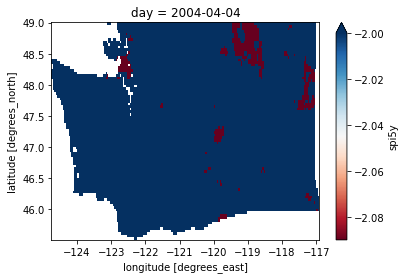

In [34]:
spi['5y'].sel(day='2004-04-04').plot(cmap='RdBu', vmax=-2)

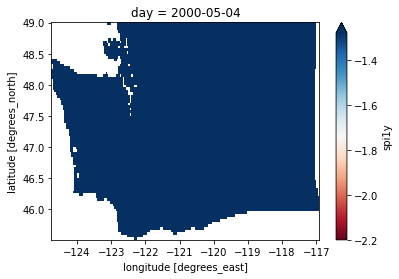

In [35]:
spi['1y'].sel(day='2000-05-04').plot(cmap='RdBu', vmax=-2)

Yeah those CAF are wayyy off. 